In [20]:
# Add the parent directory to the path so that we can import the src module
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [21]:
from src.camera import CameraCalibration, Camera, CameraPose
from src.camera.video import VideoStream
from src.segmentation.circledetector import CircleDetector
from src.segmentation.yolo_detector import SplitYoloDetector
from src.segmentation.split_image import ImageSplitter
from src.pose.position_estimation import PositionEstimation
from src.pose.velocity_regression import velocity_regression
from src.ukf import BallUKF
from src.ukf.measurement import PixelPositionMeasurementMode
from src.pingpong.ball import BallConstants
from src.pingpong.table import TableConstants
from src.fileutils import DATA_DIR, MODELS_DIR
import src.visualization.plot3D as plot3D

from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLOWorld
from scipy.spatial.transform import Rotation
from itertools import islice

In [22]:
# Define constants
CALIBRATION_VIDEO_PATH = DATA_DIR / 'calibration' / 'Priyanshu_iPhone13.MOV'
VIDEO_PATH = DATA_DIR / "videos" / "IMG_5385.MOV"

BALL = BallConstants()
TABLE = TableConstants()

CAMERA_POSITION = np.array([0, -(TABLE.net_width + 2), 0.5])
CAMERA_ORIENTATION = Rotation.from_euler('xyz', [-90, 0, 0], degrees=True)
CAMERA_MIRROR_Y = False


In [23]:
# Get camera calibration
calibration_video = VideoStream(DATA_DIR / 'calibration' / 'Priyanshu_iPhone13.MOV', frames_to_read=100)
print(calibration_video)
calibration = CameraCalibration.from_calibration_video(tqdm(calibration_video, total=calibration_video.get_length_if_known()))
calibration.intrinsic_matrix

VideoStream:
	Source: C:\Users\agpri\OneDrive\Documents\GitHub\PingPongTracking\data\calibration\Priyanshu_iPhone13.MOV
	FPS: 212.2765805331427
	Frames: 866
	Resolution: 1920x1080
	Frames to read: 100



  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:04<00:00, 22.55it/s]


array([[       1978,           0,      898.62],
       [          0,      3876.7,      549.85],
       [          0,           0,           1]])

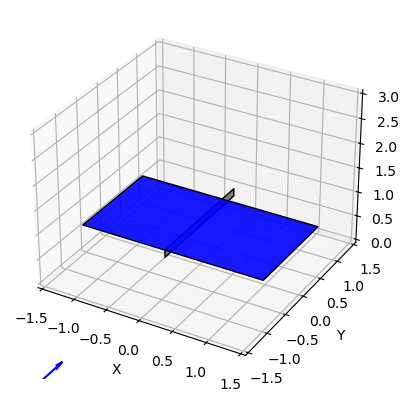

In [24]:
# Initialize camera
camera_pose = CameraPose(CAMERA_POSITION, CAMERA_ORIENTATION, mirror_y=CAMERA_MIRROR_Y)
camera = Camera(camera_pose, calibration)

# Plot the camera
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot3D.plot_table(ax, TABLE)
plot3D.plot_camera(ax, camera)

In [25]:

# Initialize position estimator and circle detector
position_estimator = PositionEstimation(camera, BALL, TABLE)
circle_detector = CircleDetector()

position_estimator.project_ball_position_table_reference_frame_to_camera_plane(np.array([0, -3, 1]))

(899, -1772, 95)

In [26]:
# Load video 
video = VideoStream(VIDEO_PATH)
dt = 1/video.fps
video

VideoStream:
	Source: C:\Users\agpri\OneDrive\Documents\GitHub\PingPongTracking\data\videos\IMG_5385.MOV
	FPS: 26.625
	Frames: 213
	Resolution: 1920x1080

In [27]:
# Init yolo
model = YOLOWorld(str(MODELS_DIR / 'yolov8l-world.pt'))
model.conf = 0.01
model.iou = 0.1

# Split the frame into smaller overlapping regions
split_height = video.height // 4
split_width = video.width // 4
overlap = 0.2
splitter = ImageSplitter(split_height=split_height, split_width=split_width, overlap=overlap)

detector = SplitYoloDetector(model, splitter)


Bounding box [821, 774, 847, 800] detected with confidence 0.7269150614738464
Ball position [   -0.09942    -0.79189     0.31384] at time 0.0


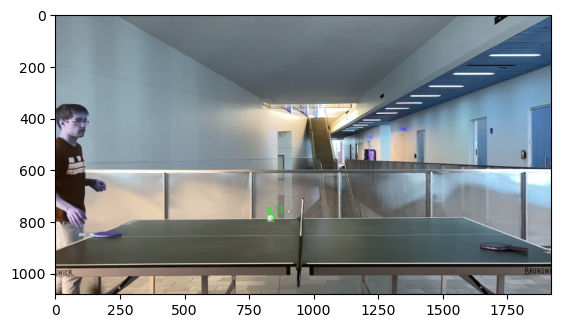

Bounding box [813, 765, 839, 788] detected with confidence 0.39700794219970703
Ball position [    -0.1263    -0.39496     0.29932] at time 0.03755868544600939


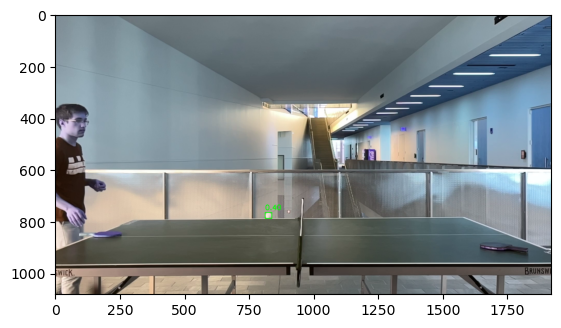

No ball detected


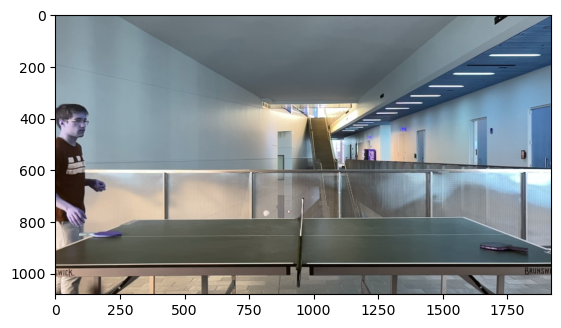

No ball detected


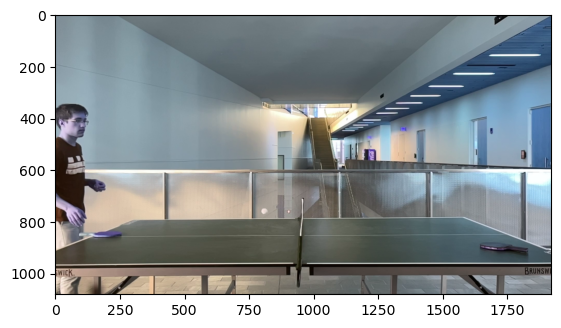

No ball detected


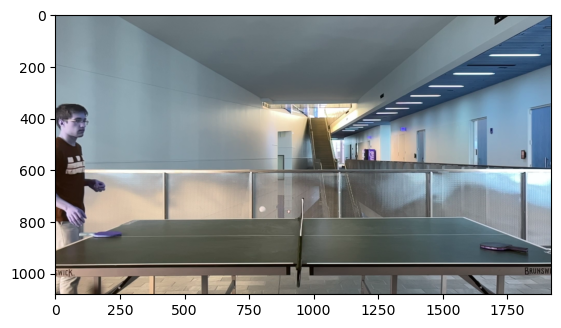

In [28]:
# Kalman Initialization Frames
n_initialization_frames = 5
initial_positions = []
initial_times = []

for i, frame in enumerate(islice(video, n_initialization_frames)):

    frame = next(video)
    box, conf = detector.detect(frame, yolo_verbose = False, debug_plots = True)
    annotated_frame = frame.copy()

    if box is not None:
        print(f"Bounding box {box} detected with confidence {conf.item()}")

        center_x = (box[0] + box[2]) // 2
        center_y = (box[1] + box[3]) // 2
        diameter = min(box[2] - box[0], box[3] - box[1])

        # Get the ball position
        ball_position = position_estimator.ball_position_table_reference_frame(center_x, center_y, diameter)
        initial_positions.append(ball_position)
        initial_times.append(i * dt)
        print(f"Ball position {ball_position} at time {i * dt}")

        x, y, x2, y2 = box
        cv2.rectangle(annotated_frame, (x, y), (x2, y2), (0, 255, 0), 2)
        cv2.putText(annotated_frame, f'{conf:.2f}', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    else:
        print("No ball detected")

    plt.figure()
    plt.imshow(annotated_frame)
    plt.show()
        

In [33]:
# Linear regression over initial positions to get initial velocity
initial_positions = np.array(initial_positions)
initial_times = np.array(initial_times)
initial_velocity = velocity_regression(initial_times, initial_positions)
print(f"Initial velocity: {initial_velocity}")


Initial velocity: [    -0.7157      10.568    -0.38661]


In [ ]:
# Initialize Kalman Filter

# Initial state is all zeros with very high covariance
initial_state = np.zeros(12)   
initial_covariance = np.eye(12) * 1

# Process noise should be relatively small
process_noise = np.eye(12) * 0.1

# Measurement noise should be relatively large
measurement_noise = np.eye(3) * 0.3
measurement_mode = PixelPositionMeasurementMode(measurement_noise, position_estimator)


ukf = BallUKF(BALL, initial_state, initial_covariance, process_noise, measurement_mode)

In [ ]:
raise

states = [ukf.state]
annotated_images = []

for i, frame in enumerate(video):

    annotated_image = frame.copy()

    # Get the high probability region in which we can find the ball    
    ukf.predict(dt)
    predicted_state = ukf.state
    lower, upper, mu, cov = ukf.get_high_likelihood_measurement_region(n_std_devs=2)
    lower, upper = np.round(lower, 0).astype(np.int64), np.round(upper, 0).astype(np.int64)

    print("Predicted State\n", predicted_state)
    print("Mu of transformed region\n", mu)
    print("Covariance of transformed region\n", cov)
    print("Lower Bound (2 STD) \n", lower)
    print("Upper Bound (2 STD) \n", upper)

    
    # Draw the ball's predicted position in orange
    predicted_projection = position_estimator.project_ball_position_table_reference_frame_to_camera_plane(predicted_state[:3])
    annotated_image = cv2.circle(annotated_image, (int(predicted_projection[0]), int(predicted_projection[1])), predicted_projection[2]//2, (0, 165, 255), 4)

    print("predicted_projection", predicted_projection)

    # Crop to likely region
    cropped_image = crop_image(frame, lower, upper)
    results = model.predict(cropped_image)
    results[0].show()
    
    # Draw the likely region in red
    annotated_image = cv2.rectangle(annotated_image, lower[:2], upper[:2], (0, 0, 255), 4)

    # Detect circles in the frame
    min_radius = max(min(lower[2] // 2, upper[2] // 2), 1)
    max_radius = min(max(lower[2] // 2, upper[2] // 2), max_allowed_ball_radius)

    

    circles = circle_detector.hough_circles(frame, min_radius, max_radius, minDist=2*min_radius, param1=50, param2=30)

    if (len(circles) == 0):
        print(f"No circles found in frame {i}, skipping ukf update this frame")
        plt.figure()
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        plt.show()
        annotated_images.append(annotated_image)
        continue
    if (len(circles) > 1):
        sensitivity = 50
        lower_white = np.array([0,0,255-sensitivity])
        upper_white = np.array([255,sensitivity,255])
        circles = circle_detector.filter_circles_by_color_threshold(frame, circles, color_low_hsv=lower_white, color_high_hsv=upper_white, threshold=0.3)
    
    if len(circles) != 1:
        print(f"Found {len(circles)} circles in frame {i}, skipping ukf update this frame")

        # Draw the detected circles in green
        annotated_image = circle_detector.draw_circles(annotated_image, circles, (0, 255, 0), 1)

        plt.figure()
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        plt.show()
        annotated_images.append(annotated_image)
        continue

    # Get the position of the ball
    ping_pong_ball = circles[0]
    ping_pong_ball_center_x = ping_pong_ball[0]
    ping_pong_ball_center_y = ping_pong_ball[1]
    ping_pong_ball_radius = ping_pong_ball[2]
    position = position_estimator.ball_position_table_reference_frame(ping_pong_ball_center_x, ping_pong_ball_center_y, ping_pong_ball_radius*2)

    ukf.update(position)
    states.append(ukf.state)

    # Draw the detected ball's circle in green
    cv2.circle(annotated_image, (ping_pong_ball_center_x, ping_pong_ball_center_y), ping_pong_ball_radius, (0, 255, 0), 2)
    plt.figure()
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.show()
    annotated_images.append(annotated_image)


RuntimeError: No active exception to reraise

In [ ]:
print(ukf.state)
print(ukf.state_covariance)

# Check symmetric positive definite
print(np.min(np.linalg.eigvals(ukf.state_covariance)))


[    -1.7193      4.3856    -0.14956     -3.1416     -3.1416      3.1416    -0.34543      0.7042     -3.9409  0.00010027  8.2146e-05 -2.4665e-13]
[[    0.54746 -2.4652e-05   0.0043282      13.054      13.054      13.053     0.28413  -0.0005414   0.0010828 -1.2545e-07 -0.00044819 -5.2275e-05]
 [-2.4652e-05     0.60795   -0.011469     -13.836     -11.933      13.831 -0.00071134     0.36068  -0.0082707  0.00049149  1.4251e-07 -2.5648e-05]
 [  0.0043282   -0.011469       0.548     -12.679     -12.711      10.913    0.003355   -0.018199      0.3241  4.3788e-05   2.491e-05  1.3275e-11]
 [     13.054     -13.836     -12.679     -12.575      3935.5     -2974.7      33.507     -36.714     -13.506     -29.801   -0.065838       -6.01]
 [     13.054     -11.933     -12.711      3935.5     -12.574      2974.7      29.313      23.588     -58.602       30.31     -29.796      5.9922]
 [     13.053      13.831      10.913     -2974.7      2974.7     -12.566      34.094      27.581      4.8116     -30.2

In [ ]:
# Save the annotated images as a video
output_path = DATA_DIR / "output" / "annotated_ukf.mp4"
writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), video.fps, (video.width, video.height))
for image in annotated_images:
    writer.write(image)
writer.release()